In [1]:
import nibabel as nib
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import random
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
from glob import glob
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import Subset, DataLoader
from torchsummary import summary
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [2]:
device = torch.device("cuda")
print(device)

cuda


## Data Processing and Exploration

### Choosing the right data:

The full dataset has been processed from it's original 350GB+ MRI dataset. The original csv file is filtered to include only 1.5T or 3.0T scans as they contain the most comprehensive sets of MRI scans of differing types (T1-weighted, T2, Bold, etc). 

The clinical dementia rating (cdr) with values (0, 0.5, 1, 2) represent 0 = absent; 0.5 = questionable; 1= present, but mild; 2 = moderate (reference: https://www.sciencedirect.com/topics/neuroscience/clinical-dementia-rating). They have been remapped from (0, 0.5, 1, 2) to (0, 1, 2, 3) due to issues processing it with Torch dataloader, leading to a missing class for 0.5 cdr.

Based on each MRI session value (Label), if there are multiple values for the cdr then the scans are excluded.

In [3]:
diagnostic_file = glob('diagnosis.csv')[0]

diagnostic_df = pd.read_csv(diagnostic_file)

diagnostic_df = diagnostic_df[(diagnostic_df.Scanner == '3.0T') | (diagnostic_df.Scanner == '1.5T')]

multiple_values = diagnostic_df.groupby('Label').filter(lambda group: group['cdr'].nunique() > 1)['Label'].unique()

cdr_map = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}

# Filter out rows with these values in column A
filtered_diagnostic_df = diagnostic_df[~diagnostic_df['Label'].isin(multiple_values)]
filtered_diagnostic_df = filtered_diagnostic_df.drop_duplicates(subset='Label')
# filtered_diagnostic_df['cdr'] = filtered_diagnostic_df['cdr'].map(cdr_map)
filtered_diagnostic_df['file_tag'] = filtered_diagnostic_df.Label.apply(lambda file_name: file_name[-5:])
print(len(filtered_diagnostic_df))

valid_mr_scans_ls = filtered_diagnostic_df.file_tag.to_list()
print(valid_mr_scans_ls[:3])
filtered_diagnostic_df.file_tag

# filtered_diagnostic_df.to_csv('filtered_data.csv')

1379
['d0129', 'd2430', 'd3132']


0       d0129
2       d2430
3       d3132
12      d0371
15      d2340
        ...  
6193    d0148
6194    d2526
6195    d1566
6216    d1717
6217    d0407
Name: file_tag, Length: 1379, dtype: object

This section is to preview the different MRI images available.

['sub-OAS30001_ses-d0757_run-01_T1w.nii.gz', 'sub-OAS30001_ses-d0757_run-02_T1w.nii.gz']


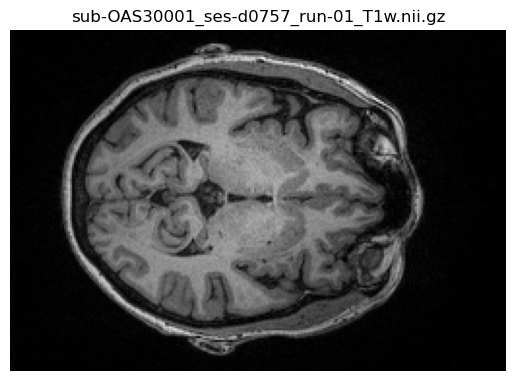

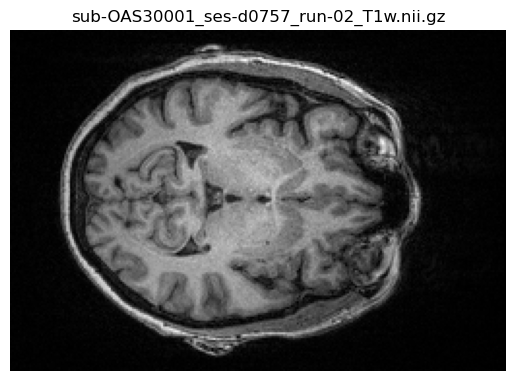

In [4]:
def display_nii_gz_files(file_path):
    # List all files in the given directory
    nii_gz_files = glob(file_path + '/**/*nii.gz', recursive=True)
    
    file_names = [file.split('\\')[-1] for file in nii_gz_files]
    print(file_names)
    # Display each .nii.gz file
    for file_name in nii_gz_files:
        try:
            img = nib.load(file_name)
            data = img.get_fdata()
            
            # Display a middle slice of the 3D image
            slice_index = data.shape[2] // 2
            plt.imshow(data[:, :, slice_index], cmap='gray')
            plt.title(file_name.split('\\')[-1])
            plt.axis('off')
            plt.show()
        except:
            print(f'Cannot show: {file_name}')

# Example usage
display_nii_gz_files('bids/sub-OAS30001/ses-d0757/')


Based on research, T1-weighted scans are one of the most widely used datasets for predicting and diagnosing dementia. It provides extremely detailed assessments of the brain's structure which can be used to find out the presence or absence, as well as the pattern for brain volume loss such as atrophy. Hence, below is the file retrieval for T1-weighted scans.

Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3486423/#:~:text=T1%20weighted%20volumetric%20MRI%20scanning,volume%20loss%2C%20ie%2C%20atrophy.

In [5]:
data_path = 'bids/' ## Change as needed

def recursive_glob_with_filter(directory, filter_list):
    # Use recursive glob pattern to find all files
    all_files = glob(directory + '/**/*T1*nii.gz', recursive=True)
    
    # Filter files based on the presence of strings from filter_list in the file path
    filtered_files = [file for file in all_files if any(filter_str in file for filter_str in filter_list)]
    
    return filtered_files

file_ls = recursive_glob_with_filter(data_path, valid_mr_scans_ls)
print(file_ls[:2])

['bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-01_T1w.nii.gz', 'bids\\sub-OAS30001\\ses-d0129\\anat\\sub-OAS30001_ses-d0129_run-02_T1w.nii.gz']


In [6]:
# Function to extract tag from file path
def extract_tag_from_file_path(file_path):
    file_path = file_path.replace(data_path[:-1], '')
    return file_path.split('\\')[2][-5:]

try:
    data_loader_df = pd.read_csv('data_loader_df.csv')
except:
    # Create a new DataFrame to store the results
    data_loader_df = pd.DataFrame(columns=['file_path', 'label'])

    # Iterate over the file list and find the corresponding CDR value
    for file_path in file_ls:
        tag = extract_tag_from_file_path(file_path)
        cdr_value = filtered_diagnostic_df.loc[filtered_diagnostic_df['file_tag'] == tag, 'cdr'].values
        if cdr_value.size > 0:  # Check if cdr_value is not empty
            new_row = pd.DataFrame({'file_path': [file_path], 'label': [cdr_value[0]]})
            data_loader_df = pd.concat([data_loader_df, new_row], ignore_index=True)
            data_loader_df.to_csv('data_loader_df.csv')

print(data_loader_df)

      Unnamed: 0                                          file_path  label
0              0  bids\sub-OAS30001\ses-d0129\anat\sub-OAS30001_...    0.0
1              1  bids\sub-OAS30001\ses-d0129\anat\sub-OAS30001_...    0.0
2              2  bids\sub-OAS30001\ses-d2430\anat\sub-OAS30001_...    0.0
3              3  bids\sub-OAS30001\ses-d3132\anat\sub-OAS30001_...    0.0
4              4  bids\sub-OAS30001\ses-d3746\anat\sub-OAS30001_...    0.0
...          ...                                                ...    ...
1535        1535  bids\sub-OAS30673\ses-d0043\anat\sub-OAS30673_...    0.0
1536        1536  bids\sub-OAS30673\ses-d1135\anat\sub-OAS30673_...    0.0
1537        1537  bids\sub-OAS30673\ses-d1135\anat\sub-OAS30673_...    0.0
1538        1538  bids\sub-OAS30673\ses-d2417\anat\sub-OAS30673_...    0.0
1539        1539  bids\sub-OAS30673\ses-d2417\anat\sub-OAS30673_...    0.0

[1540 rows x 3 columns]


This section is to extract 2D slices from 3D volumetric MRI scans. It iterates through the T1-weighted scans and slices between indexes 100-160, choosing a slice for every 3 slices. If the scan has less then 160 slices, then the middle slice will be taken of which there is only 1. Eventually there should be a dataset of 58,376. 

JPG is the saved file format due to its smaller size. NPY was tried but was 840GB and hence rejected.

**Run only once (roughly 7-20 mins depending on CPU).**

Due to an extremely imbalanced dataset (Label 0.0: 50216; Label 1.0: 5748; Label 2.0: 1971; Label 3.0: 441), weights will be used. 

In [7]:
from collections import defaultdict
import os
import pandas as pd
import torch

save_dir = data_path[:-5] + "preprocessed_images"
# Dictionary to store the count of each label
class_counts = defaultdict(int)

# List to store file paths and labels
file_paths_labels = []

# Iterate over all files in the save directory
for filename in os.listdir(save_dir):
    if filename.startswith("label_") and filename.endswith(".jpg"):
        # Extract the label from the filename and convert it to a decimal (float)
        label = float(filename.split("_")[1])
        # Increment the count for this label
        class_counts[label] += 1
        # Append the full file path and label to the list
        full_path = os.path.join(save_dir, filename)
        file_paths_labels.append((full_path, label))

dementia_count = 0
healthy_count = 0
# Print the count of each label
for label, count in class_counts.items():
    print(f"Label {label}: {count}")
    if label >0:
        dementia_count+=count
    else:
        healthy_count+=count
# Create a DataFrame from the list of file paths and labels
jpg_data_loader_df = pd.DataFrame(file_paths_labels, columns=['file_path', 'label'])

## Print the first few rows of the DataFrame
# print(jpg_data_loader_df.head())

# Calculate weights: Inverse of the frequency seems like a simple choice
total_count = sum(class_counts.values())
weights = {k: total_count / v for k, v in class_counts.items()}
print(weights)
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Convert weights to a tensor, ensuring the labels are in the correct order
weights_tensor = torch.tensor([weights[0], weights[1], weights[2], weights[3]], dtype=torch.float32)

print(weights_tensor)
weights_tensor = weights_tensor.to(device)
jpg_data_loader_df.to_csv('jpg_data_loader_df.csv')

all_dementia_weight = (healthy_count+dementia_count)/dementia_count
# all_dementia_weight = 3
print(all_dementia_weight)


Label 0.0: 26056
Label 1.0: 2611
Label 2.0: 970
Label 3.0: 273
{0.0: 1.1479121891311022, 1.0: 11.45538108004596, 2.0: 30.835051546391753, 3.0: 109.56043956043956}
cuda
tensor([  1.1479,  11.4554,  30.8351, 109.5604])
7.760768033212247


## Functions

Functions for training the model. Includes NiftiDataset, HierarchicalCrossEntropyLoss, load_model, train_model and evaluate_model.

In [8]:
from torch.utils.data import DataLoader, random_split

class NiftiDataset(Dataset):
    def __init__(self, dataframe, preprocessed_dir):
        self.dataframe = dataframe
        self.preprocessed_dir = preprocessed_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        img_path = row['file_path']  # Use the exact path from the dataframe
        scan = cv2.imread(img_path)
        # scan = cv2.resize(scan, (224,224), interpolation=cv2.INTER_LINEAR)
        scan = scan / 255.0  # Normalize the image to [0, 1]
        scan_tensor = torch.from_numpy(scan).float()
        
        # If the image is grayscale, we use unsqueeze to add the channel dimension
        if len(scan.shape) == 2:
            scan_tensor = scan_tensor.unsqueeze(0)  # Add channel dimension for grayscale image
        else:
            scan_tensor = scan_tensor.permute(2, 0, 1)  # Rearrange dimensions for color image
        
        label_tensor = torch.tensor(label).long()

        return scan_tensor, label_tensor

dataset = NiftiDataset(jpg_data_loader_df, preprocessed_dir=save_dir)

# Create a list of labels for stratified splitting
labels = jpg_data_loader_df.iloc[:, 1].values
myset = set(labels)
print(myset)

# Define the ratios for splitting
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the sizes for each split
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Create dataloaders for each split
batch_size = 32  # Adjust the batch size as needed
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count labels in a dataset
def count_labels(dataset):
    label_counts = {}
    for _, label_tensor in dataset:
        label = label_tensor.item()
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    return label_counts

# Print the sizes and label counts of each split
print(f'Train set size: {len(train_dataloader.dataset)}')
# print(f'Train set label count: {count_labels(train_dataloader.dataset)}')
print(f'Validation set size: {len(val_dataloader.dataset)}')
# print(f'Validation set label count: {count_labels(val_dataloader.dataset)}')
print(f'Test set size: {len(test_dataloader.dataset)}')
# print(f'Test set label count: {count_labels(test_dataloader.dataset)}')

{0.0, 1.0, 2.0, 3.0}
Train set size: 20937
Validation set size: 5982
Test set size: 2991


### Ensemble learning

In [18]:
import os
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_ensemble(models, test_dataloader, device):
    predictions = []
    all_labels = []

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        ensemble_outputs = []
        for model in models:
            model.eval()
            outputs = model(inputs)

            if hasattr(outputs, 'aux_logits'):
                outputs = outputs.logits

            ensemble_outputs.append(outputs)

        ensemble_outputs = torch.stack(ensemble_outputs, dim=0)
        ensemble_mean = torch.mean(ensemble_outputs, dim=0)
        _, predicted = torch.max(ensemble_mean, dim=1)

        predictions.extend(predicted.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    accuracy = torch.sum(torch.tensor(predictions) == torch.tensor(all_labels)).item() / len(predictions)
    f1 = f1_score(all_labels, predictions, average='macro')
    precision = precision_score(all_labels, predictions, average='macro')
    recall = recall_score(all_labels, predictions, average='macro')
    
    print(f'Test Accuracy: {accuracy:.4f}, Test F1: {f1:.4f}, Test Precision: {precision:.4f}, Test Recall: {recall:.4f}')


In [10]:
def load_model(model, model_name, model_type='best'):
    if model_type=='best':
        model_path = os.path.join('checkpoints/', f'best_{model_name}.pth')
    else:
        model_path = os.path.join(glob('checkpoints/' + f'{model_name}_epoch_*.pth')[-1])
    checkpoint = torch.load(model_path, map_location=torch.device('cuda'))
    model.load_state_dict(checkpoint)

In [11]:
resnet = models.resnet18()
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 4)

checkpoint = torch.load("checkpoints\\best_resnet18_w_crossentropy.pth", map_location=torch.device('cpu'))
resnet.load_state_dict(checkpoint)

<All keys matched successfully>

In [12]:
inception = models.inception_v3()
num_features = inception.fc.in_features
inception.fc = nn.Linear(num_features,4)

num_features_aux = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(num_features_aux, 4)

checkpoint = torch.load("checkpoints\\inception_v3_w_crossentropy", map_location=torch.device('cpu'))
inception.load_state_dict(checkpoint)

c:\Users\GigaB\anaconda3\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


<All keys matched successfully>

In [13]:
import timm
vit = timm.create_model('vit_small_patch16_224', pretrained=False)

# Modify the final layer to match the number of classes (4 in this case)
num_features = vit.head.in_features
vit.head = nn.Linear(num_features, 4)
checkpoint = torch.load("checkpoints\\best_vit_small_patch16_224.pth", map_location=torch.device('cpu'))
vit.load_state_dict(checkpoint)

<All keys matched successfully>

In [19]:
models = [resnet, inception]
device = torch.device("cpu")
evaluate_ensemble(models, test_dataloader, device)

Test Accuracy: 0.9408, Test F1: 0.8502, Test Precision: 0.8929, Test Recall: 0.8185


In [20]:
models = [resnet, vit]
device = torch.device("cpu")
evaluate_ensemble(models, test_dataloader, device)

Test Accuracy: 0.8429, Test F1: 0.6714, Test Precision: 0.5794, Test Recall: 0.9160


In [21]:
models = [vit, inception]
device = torch.device("cpu")
evaluate_ensemble(models, test_dataloader, device)

Test Accuracy: 0.7807, Test F1: 0.3233, Test Precision: 0.4542, Test Recall: 0.3132


In [22]:
models = [resnet, vit, inception]
device = torch.device("cpu")
evaluate_ensemble(models, test_dataloader, device)

Test Accuracy: 0.9375, Test F1: 0.8479, Test Precision: 0.8628, Test Recall: 0.8372
